In [3]:
import numpy as np
import pandas as pd

df = pd.read_csv("cluster_label_for_dataset.csv")
print(df.columns)
df = df[['lat', 'long', 'population', 'conflict_intensity', 'corruption_perception_index','solar', 'wind_speed', 'kmeans_label', 'birch_label', 'gaussian_label']]

Index(['Unnamed: 0.1', 'Unnamed: 0', 'lat', 'long', 'population', 'iso3_code',
       'corruption_perception_index', 'conflict_intensity', 'solar',
       'wind_speed', 'kmeans_label', 'weight', 'birch_label',
       'gaussian_label'],
      dtype='object')


In [4]:
# get min and max of lat and long
minLat = df['lat'].min()
maxLat = df['lat'].max()
minLong = df['long'].min()
maxLong = df['long'].max()
print(minLat, maxLat, minLong, maxLong)
sortedDF = df.sort_values(by=['lat', 'long'])
# iterate through each row of sortedDF and print the row
latIdx = 0
lonIdx = 0


-34.83333333333334 37.583333333333336 -17.583333333333343 63.5


In [5]:
latDiff = 13.458333333333329 - 13.416666666666655
longDiff = 8.958333333333343 - 8.916666666666657
THRESHOLD = 0.0000001
def isPoint(latX, lonX, latY, lonY):
    if abs(latX - latY) <= THRESHOLD and abs(lonX - lonY) <= THRESHOLD:
        return True
    return False
arr = []
arrRow = []
lons = []
lats = []
idx = 0

latIdx = 0
lonIdx = 0
sortedDF = df.sort_values(by=['lat', 'long'])
while minLong + lonIdx * longDiff < maxLong + THRESHOLD:
    lons.append(minLong + lonIdx * longDiff)
    lonIdx += 1
while minLat + latIdx * latDiff < maxLat + THRESHOLD:
    lats.append(minLat + latIdx * latDiff)
    latIdx += 1
lonIdx = 0
latIdx = 0
appendToLons = True
for index, row in sortedDF.iterrows():
    if idx % 100000 == 0:
        print(idx)
    idx += 1
    while not isPoint(minLat + latIdx * latDiff, minLong + lonIdx * longDiff, row['lat'], row['long']):
        
        arrRow.append(np.NaN)
        lonIdx += 1
        
        if minLong + lonIdx * longDiff > maxLong + THRESHOLD:
            appendToLons = False
            arr.append(arrRow)
            arrRow = []
            lonIdx = 0
            latIdx += 1
            
            if minLat + latIdx * latDiff > maxLat + THRESHOLD:
                print("ERR", minLat + latIdx * latDiff, maxLat, minLong + lonIdx * longDiff, maxLong)
                print(row)
                break
    
    # arrRow.append(row['solar'])
    arrRow.append({
        "solar": row['solar'],
        "wind_speed": row['wind_speed'],
        "population": row['population'],
        "kmeans_label": row['kmeans_label'],
        "birch_label": row['birch_label'],
        "gaussian_label": row['gaussian_label'],
        "conflict_intensity": row['conflict_intensity'],
        "corruption_perception_index": row['corruption_perception_index']
    })
    # ['population', 'conflict_intensity', 'corruption_perception_index','solar', 'wind_speed', 'kmeans_label', 'birch_label', 'gaussian_label']
    #  df[['lat', 'long', 'population', 'iso3_code', 'solar', 'wind_speed', 'kmeans_label', 'birch_label', 'gaussian_label']]
    lonIdx += 1
    if minLong + lonIdx * longDiff > maxLong + THRESHOLD:
        arr.append(arrRow)
        arrRow = []
        lonIdx = 0
        latIdx += 1
while len(arrRow) < len(arr[0]):
    arrRow.append(np.NaN)
arr.append(arrRow)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000


In [29]:
# import basemap


1739 1947
974 870 870


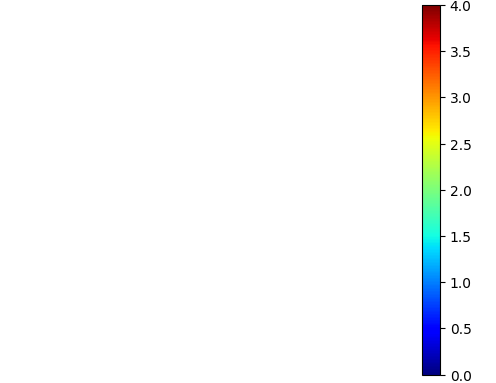

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from PIL import Image

import matplotlib as mpl

lonsMesh, latsMesh = np.meshgrid(lons, lats)
def plotFig(figArr, name):
    plt.clf()
    npGrid = np.ma.masked_equal(np.array(figArr), np.NaN)

    m = Basemap(llcrnrlat=minLat, urcrnrlat=maxLat, llcrnrlon=minLong, urcrnrlon=maxLong, epsg=3857, fix_aspect=False, projection='merc', ellps="WGS84")

    # m.drawcoastlines()
    # m.drawcountries()
    
    plt.axis("off")
    mpl.rcParams['savefig.pad_inches'] = 0
    # plt.margins((0,0))
    plt.gca().set_axis_off()
    # plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                # hspace = 0, wspace = 0)
    plt.margins(0,0)
    # plt.autoscale(tight=True)
    plt.rcParams["figure.autolayout"] = False
    mpcm = m.pcolormesh(lonsMesh, latsMesh, npGrid, latlon=True, cmap='jet', snap=False)
    plt.savefig(name + ".png", dpi=500, bbox_inches='tight', pad_inches=0)
    
    plt.clf()
    plt.colorbar(mpcm)
    plt.axis("off")
    plt.savefig(name + "_colorbar.png", dpi=500, bbox_inches='tight', pad_inches=0)

    img = Image.open(name + "_colorbar.png")

    # crop the white off the left side of the image
    img = img.crop((2000, 0, img.size[0], img.size[1]))
    img.save(name + "_colorbar.png", "PNG")
    for image in [name + ".png", name + "_colorbar.png"]:
        img = Image.open(image)
        img = img.convert("RGBA")
        datas = img.getdata()
        newData = []
        for item in datas:
            if item[0] == 255 and item[1] == 255 and item[2] == 255:
                newData.append((255, 255, 255, 0))
            else:
                newData.append(item)
        img.putdata(newData)
        img.save(image, "PNG")

plt.show()
items = ['population', 'conflict_intensity', 'corruption_perception_index','solar', 'wind_speed', 'kmeans_label', 'birch_label', 'gaussian_label']
# items = ['conflict_intensity']
for colName in items:
    figArr = []
    for row in arr:
        figArrRow = []
        for item in row:
            if item is np.NaN:
                figArrRow.append(np.NaN)
            else:
                figArrRow.append(item[colName])
        figArr.append(figArrRow)
    plotFig(figArr, colName)

In [77]:
# make all white transparent from output.png
from PIL import Image
img = Image.open("output.png")
img = img.convert("RGBA")
datas = img.getdata()
newData = []
for item in datas:
    if item[0] == 255 and item[1] == 255 and item[2] == 255:
        newData.append((255, 255, 255, 0))
    else:
        newData.append(item)
img.putdata(newData)
img.save("output1.png", "PNG")
